# LAB4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# Ignorer les avertissements pour plus de clarté
warnings.filterwarnings("ignore")

#######################################################
### PART 1 (LAB 4): EXPLORATION, PREPROCESSING & BASELINE ###
#######################################################

--- 1.1 Data Loading & Cleaning ---
File 'electric_vehicles_spec_2025.csv.csv' loaded successfully.
Dataset Shape: (478, 22)
Cleaning 'cargo_volume_l' column...

--- 1.2 General Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kwh       478 non-null    float64
 4   battery_type               478 non-null    object 
 5   number_of_cells            276 non-null    float64
 6   torque_nm                  471 non-null    float64
 7   efficiency_wh_per

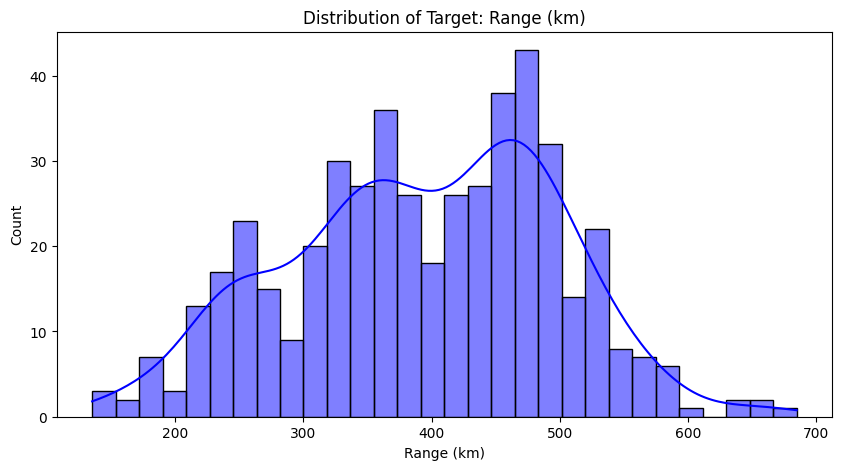

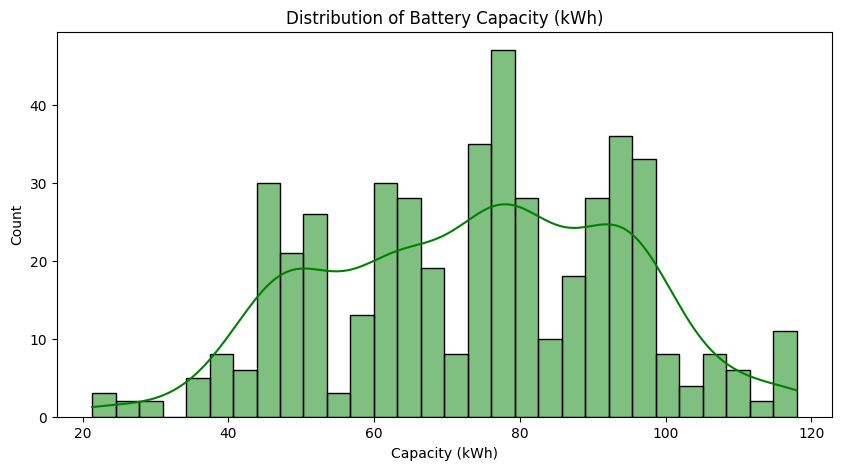

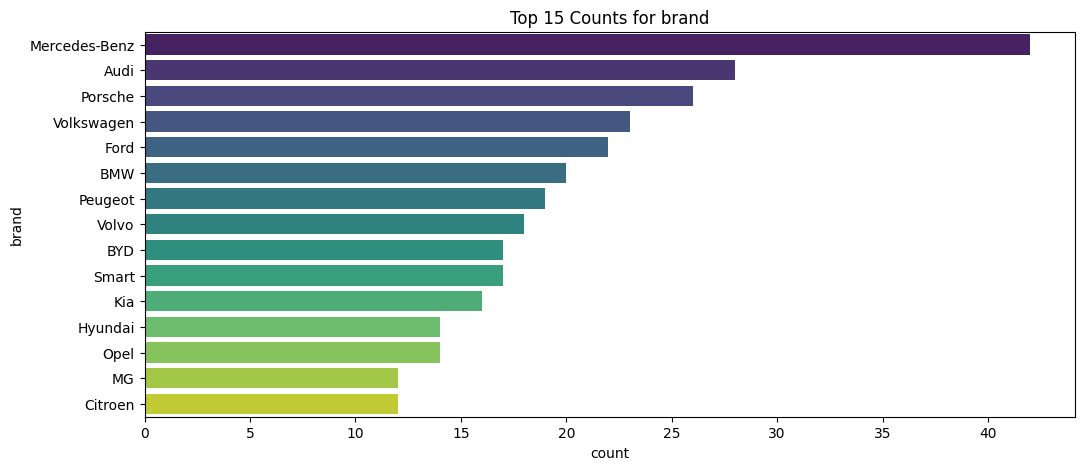


Top counts for brand:
brand
Mercedes-Benz    42
Audi             28
Porsche          26
Volkswagen       23
Ford             22
BMW              20
Peugeot          19
Volvo            18
BYD              17
Smart            17
Kia              16
Hyundai          14
Opel             14
MG               12
Citroen          12
Name: count, dtype: int64


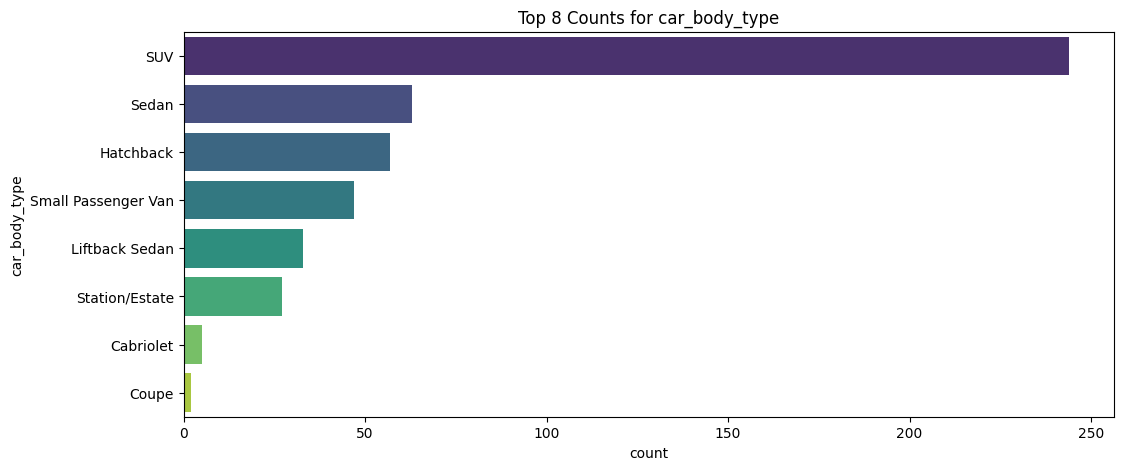


Top counts for car_body_type:
car_body_type
SUV                    244
Sedan                   63
Hatchback               57
Small Passenger Van     47
Liftback Sedan          33
Station/Estate          27
Cabriolet                5
Coupe                    2
Name: count, dtype: int64


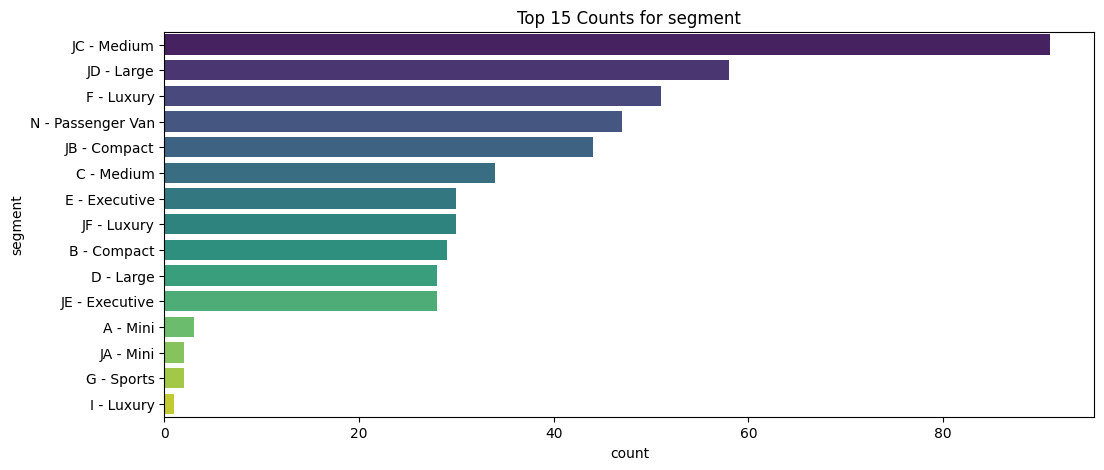


Top counts for segment:
segment
JC - Medium          91
JD - Large           58
F - Luxury           51
N - Passenger Van    47
JB - Compact         44
C - Medium           34
E - Executive        30
JF - Luxury          30
B - Compact          29
D - Large            28
JE - Executive       28
A - Mini              3
JA - Mini             2
G - Sports            2
I - Luxury            1
Name: count, dtype: int64


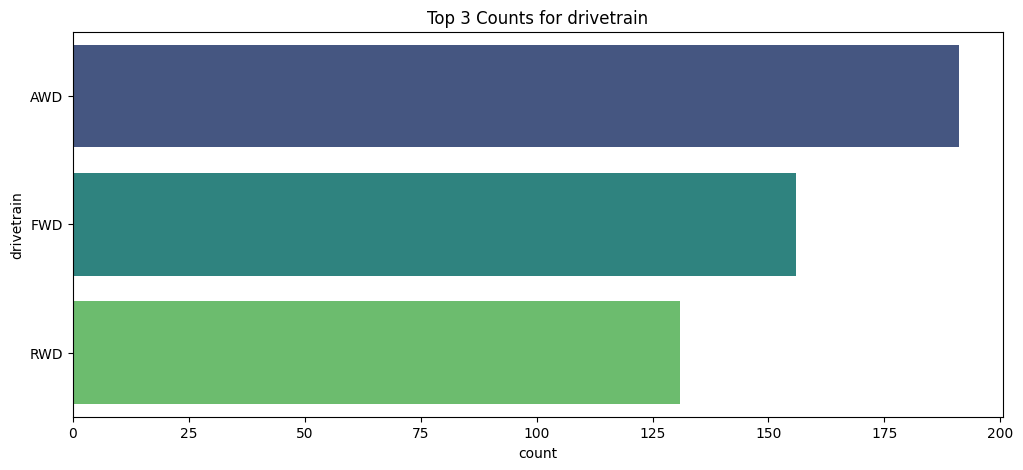


Top counts for drivetrain:
drivetrain
AWD    191
FWD    156
RWD    131
Name: count, dtype: int64

--- Visualization: Boxplots (Outlier Detection) ---


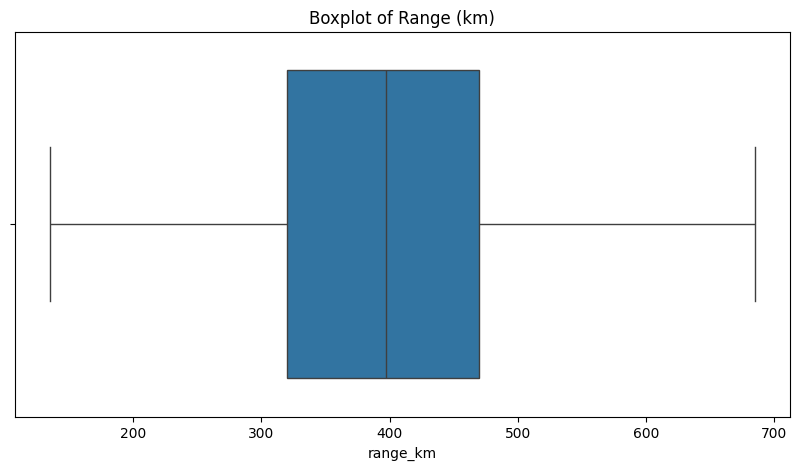

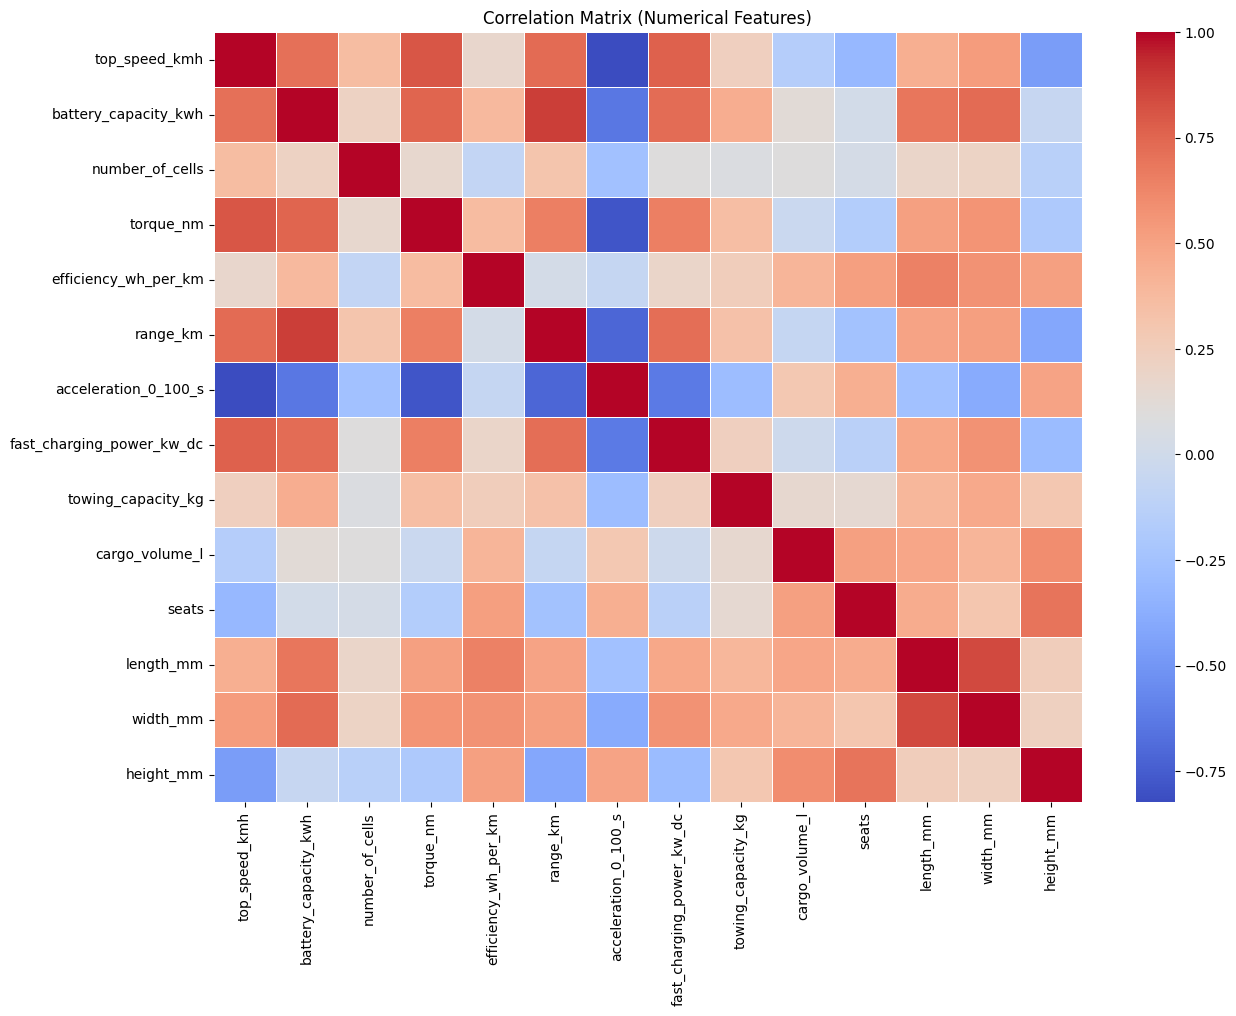


Top 10 features correlated with 'range_km':
range_km                     1.000000
battery_capacity_kwh         0.880433
top_speed_kmh                0.732130
fast_charging_power_kw_dc    0.720932
torque_nm                    0.651651
width_mm                     0.521392
length_mm                    0.496867
towing_capacity_kg           0.333962
number_of_cells              0.311014
efficiency_wh_per_km         0.022943
Name: range_km, dtype: float64

--- 2. Pre-processing Implementation ---
Numerical Features (13): ['top_speed_kmh', 'battery_capacity_kwh', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc', 'towing_capacity_kg', 'cargo_volume_l', 'seats', 'length_mm', 'width_mm', 'height_mm']
Categorical Features (6): ['brand', 'battery_type', 'fast_charge_port', 'drivetrain', 'segment', 'car_body_type']
Data Split: Train shape (382, 19), Test shape (96, 19)

--- 3. Problem Formalization ---
Type: Supervised Regression
Goal: Pr

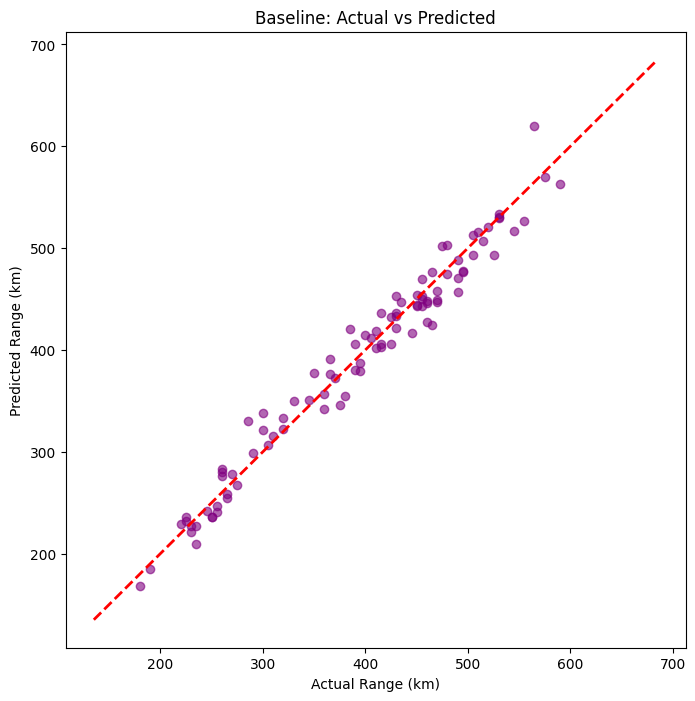

In [2]:
print("#######################################################")
print("### PART 1 (LAB 4): EXPLORATION, PREPROCESSING & BASELINE ###")
print("#######################################################")

# ==========================================
# 1. DESCRIPTIVE ANALYSIS
# ==========================================
print("\n--- 1.1 Data Loading & Cleaning ---")

try:
    # Chargement du fichier spécifique
    filename = 'electric_vehicles_spec_2025.csv.csv'
    # Le fichier semble utiliser la virgule comme séparateur standard
    df = pd.read_csv(filename)
    
    # Nettoyage des noms de colonnes : suppression des espaces et minuscules
    df.columns = df.columns.str.strip().str.lower()
    
    print(f"File '{filename}' loaded successfully.")
    print(f"Dataset Shape: {df.shape}")
    
    # Nettoyage spécifique pour ce dataset : 'cargo_volume_l' est souvent objet
    if 'cargo_volume_l' in df.columns and df['cargo_volume_l'].dtype == 'object':
        print("Cleaning 'cargo_volume_l' column...")
        df['cargo_volume_l'] = pd.to_numeric(df['cargo_volume_l'], errors='coerce')
        
except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found. Please upload it.")
    exit()

print("\n--- 1.2 General Information ---")
df.info()

print("\n--- 1.3 Descriptive Statistics (Numerical) ---")
# Sélection des colonnes numériques
numerical_cols_desc = df.select_dtypes(include=np.number).columns.tolist()
print(df[numerical_cols_desc].describe())

print("\n--- 1.4 Visualizations ---")

# Distribution de la cible : Range
plt.figure(figsize=(10, 5))
sns.histplot(df['range_km'], kde=True, bins=30, color='blue')
plt.title('Distribution of Target: Range (km)')
plt.xlabel('Range (km)')
plt.show()

# Distribution d'une caractéristique clé : Capacité Batterie
plt.figure(figsize=(10, 5))
sns.histplot(df['battery_capacity_kwh'], kde=True, bins=30, color='green')
plt.title('Distribution of Battery Capacity (kWh)')
plt.xlabel('Capacity (kWh)')
plt.show()

# Analyse des variables catégorielles
# On adapte les noms de colonnes à ce dataset spécifique
categorical_cols_viz = ['brand', 'car_body_type', 'segment', 'drivetrain']
for col in categorical_cols_viz:
    if col in df.columns:
        plt.figure(figsize=(12, 5))
        # Top 15 pour éviter de surcharger le graphique
        top_n = 15
        counts = df[col].value_counts()
        actual_n = min(top_n, len(counts))
        top_categories = counts.nlargest(actual_n).index
        
        sns.countplot(data=df[df[col].isin(top_categories)], y=col, order=top_categories, palette='viridis')
        plt.title(f'Top {actual_n} Counts for {col}')
        plt.show()
        print(f"\nTop counts for {col}:\n{counts.head(actual_n)}")

# Ajout spécifique pour le Lab 4 : Boxplots pour les outliers
print("\n--- Visualization: Boxplots (Outlier Detection) ---")
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['range_km'])
plt.title('Boxplot of Range (km)')
plt.show()

# Matrice de Corrélation
plt.figure(figsize=(14, 10))
corr_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

print("\nTop 10 features correlated with 'range_km':")
print(corr_matrix['range_km'].sort_values(ascending=False).head(10))


# ==========================================
# 2. PRE-PROCESSING IMPLEMENTATION
# ==========================================
print("\n--- 2. Pre-processing Implementation ---")

# 1. Définir Cible (y) et Caractéristiques (X)
target = 'range_km'
# On retire la cible et les colonnes inutiles ou trop complexes pour la baseline
drop_cols = [target, 'source_url'] 
if 'model' in df.columns:
    drop_cols.append('model') # Trop de cardinalité pour une baseline simple

X = df.drop(columns=drop_cols, errors='ignore')
y = df[target]

# 2. Identifier les types de caractéristiques
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")

# 3. Définir les transformateurs
# Numérique : Imputation (Médiane) + Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Catégoriel : Imputation (Constante) + Encodage OneHot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 4. Créer le ColumnTransformer (Le Préprocesseur)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# 5. Division Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data Split: Train shape {X_train.shape}, Test shape {X_test.shape}")


# ==========================================
# 3. PROBLEM FORMALIZATION
# ==========================================
print("\n--- 3. Problem Formalization ---")
print("Type: Supervised Regression")
print("Goal: Predict the 'range_km' (autonomy) of an EV based on technical specifications.")
print("Metrics: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), R2 Score.")


# ==========================================
# 4. BASELINE MODEL SELECTION & IMPLEMENTATION
# ==========================================
print("\n--- 4. Baseline Model ---")

# 4.1 Baseline Naïve (Dummy Regressor - Prédit la moyenne)
dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
print(f"Naive Baseline (Dummy Mean) RMSE: {rmse_dummy:.2f} km")

# 4.2 Baseline Forte (Régression Linéaire)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression(n_jobs=-1))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Métriques pour la Régression Linéaire
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\nSelected Baseline: Linear Regression Results")
print(f"MAE:  {mae_lr:.2f} km")
print(f"RMSE: {rmse_lr:.2f} km")
print(f"R2:   {r2_lr:.4f}")

# Visualisation de la performance de la baseline
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Ligne d'identité
plt.xlabel('Actual Range (km)')
plt.ylabel('Predicted Range (km)')
plt.title('Baseline: Actual vs Predicted')
plt.show()

# LAB5


#######################################################
### PART 2 (LAB 5): FEATURE SELECTION & DIMENSIONALITY REDUCTION ###
#######################################################

--- 5. Feature Selection using RFE (Recursive Feature Elimination) ---
Fitting RFE (this may take a moment)...

Top 10 Selected Features by RFE:
 - num__top_speed_kmh
 - num__battery_capacity_kwh
 - num__number_of_cells
 - num__efficiency_wh_per_km
 - num__acceleration_0_100_s
 - num__fast_charging_power_kw_dc
 - num__cargo_volume_l
 - num__length_mm
 - num__height_mm
 - cat__segment_F - Luxury

Model with RFE Selected Features Results:
RMSE: 24.82 km
R2:   0.9418

--- 6. Dimensionality Reduction using PCA ---
PCA preserved 95% variance with 25 components (down from 99 features).


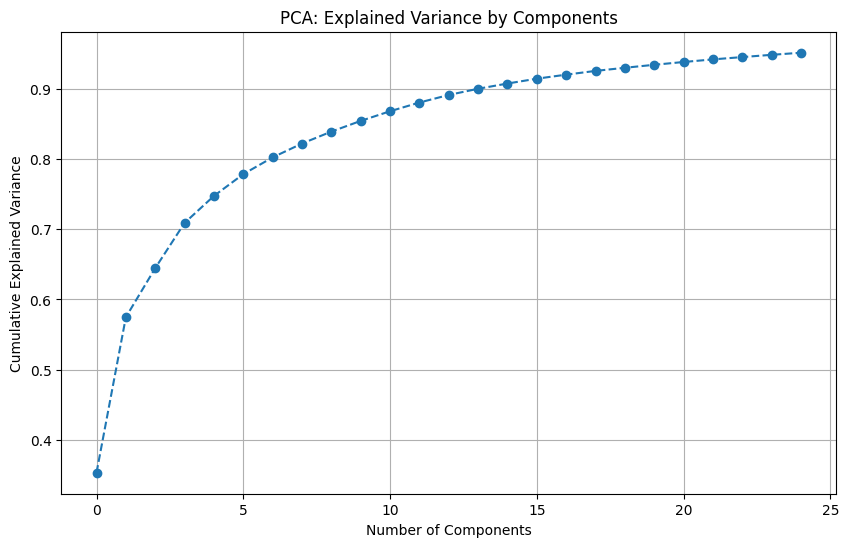


Model with PCA Results:
RMSE: 21.36 km
R2:   0.9569

--- 7. Comparison: Baseline vs Feature Selection vs PCA ---
                         Model      RMSE       R2
       Baseline (All Features) 18.036117 0.969258
       Feature Selection (RFE) 24.818349 0.941791
Dimensionality Reduction (PCA) 21.356526 0.956897


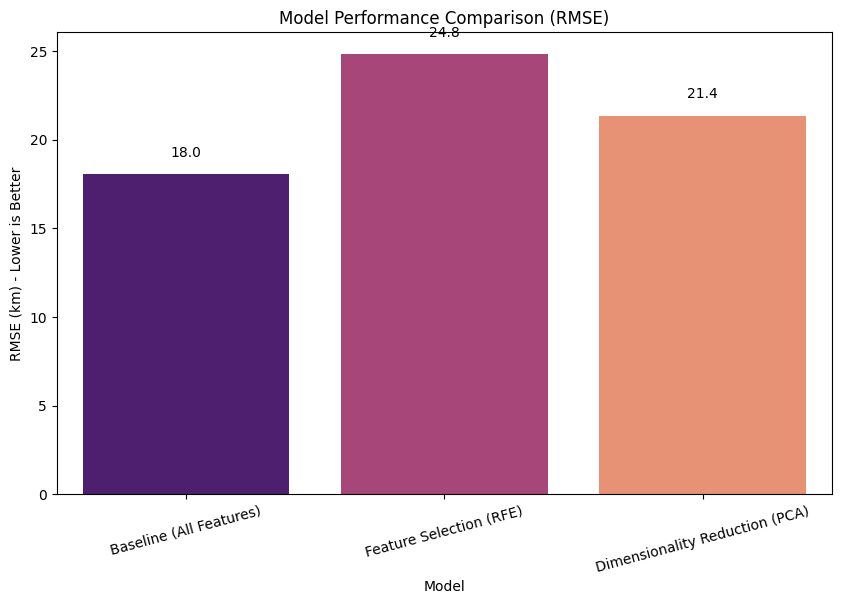

In [3]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n#######################################################")
print("### PART 2 (LAB 5): FEATURE SELECTION & DIMENSIONALITY REDUCTION ###")
print("#######################################################")

# ==========================================
# 5. FEATURE SELECTION (RFE)
# ==========================================
print("\n--- 5. Feature Selection using RFE (Recursive Feature Elimination) ---")

# 1. Prepare the data with the preprocessor defined in Part 1
# We need to transform the data first to apply RFE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
feature_names = preprocessor.get_feature_names_out()

# 2. Initialize RFE with a base estimator (RandomForest is good for feature importance)
# We select the top 10 features
rfe_selector = RFE(estimator=RandomForestRegressor(n_jobs=-1, random_state=42), 
                   n_features_to_select=10, 
                   step=1)

print("Fitting RFE (this may take a moment)...")
rfe_selector.fit(X_train_processed, y_train)

# 3. Identify Selected Features
selected_mask = rfe_selector.support_
selected_features = feature_names[selected_mask]

print(f"\nTop 10 Selected Features by RFE:")
for feature in selected_features:
    print(f" - {feature}")

# 4. Train and Evaluate a model using ONLY selected features
# We use LinearRegression again to compare fairly with the Baseline
lr_rfe = LinearRegression(n_jobs=-1)
lr_rfe.fit(X_train_processed[:, selected_mask], y_train)
y_pred_rfe = lr_rfe.predict(X_test_processed[:, selected_mask])

rmse_rfe = np.sqrt(mean_squared_error(y_test, y_pred_rfe))
r2_rfe = r2_score(y_test, y_pred_rfe)

print(f"\nModel with RFE Selected Features Results:")
print(f"RMSE: {rmse_rfe:.2f} km")
print(f"R2:   {r2_rfe:.4f}")


# ==========================================
# 6. DIMENSIONALITY REDUCTION (PCA)
# ==========================================
print("\n--- 6. Dimensionality Reduction using PCA ---")

# 1. Apply PCA
# We want to keep 95% of the variance
pca = PCA(n_components=0.95, random_state=42)

# Fit PCA on the processed training data
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

n_components = pca.n_components_
print(f"PCA preserved 95% variance with {n_components} components (down from {X_train_processed.shape[1]} features).")

# 2. Visualize Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance by Components')
plt.grid(True)
plt.show()

# 3. Train and Evaluate a model using PCA components
lr_pca = LinearRegression(n_jobs=-1)
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

rmse_pca = np.sqrt(mean_squared_error(y_test, y_pred_pca))
r2_pca = r2_score(y_test, y_pred_pca)

print(f"\nModel with PCA Results:")
print(f"RMSE: {rmse_pca:.2f} km")
print(f"R2:   {r2_pca:.4f}")


# ==========================================
# 7. COMPARISON WITH BASELINE
# ==========================================
print("\n--- 7. Comparison: Baseline vs Feature Selection vs PCA ---")

# Collect results
results_lab5 = pd.DataFrame({
    'Model': ['Baseline (All Features)', 'Feature Selection (RFE)', 'Dimensionality Reduction (PCA)'],
    'RMSE': [rmse_lr, rmse_rfe, rmse_pca],  # rmse_lr comes from Part 1
    'R2': [r2_lr, r2_rfe, r2_pca]          # r2_lr comes from Part 1
})

print(results_lab5.to_string(index=False))

# Visualization Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_lab5, palette='magma')
plt.title('Model Performance Comparison (RMSE)')
plt.ylabel('RMSE (km) - Lower is Better')
plt.xticks(rotation=15)
for index, row in results_lab5.iterrows():
    plt.text(index, row.RMSE + 1, f"{row.RMSE:.1f}", color='black', ha="center")
plt.show()